# BlackBox Evasion

## HopSkipJump 

In [2]:
import torch
from PIL import Image
from IPython import display

import pandas as pd
import torchvision
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device.type

'cpu'

In [4]:
#load the model from the pytorch hub
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', weights='MobileNet_V2_Weights.DEFAULT', verbose=False)

# Put model in evaluation mode
model.eval()

# put the model on a GPU if available, otherwise CPU
model.to(device);

In [5]:
# Define the transforms for preprocessing
preprocess = transforms.Compose([
    transforms.Resize(256),  # Resize the image to 256x256
    transforms.CenterCrop(224),  # Crop the image to 224x224 about the center
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # Normalize the image with the ImageNet dataset mean values
        std=[0.229, 0.224, 0.225]  # Normalize the image with the ImageNet dataset standard deviation values
    )
]);

unnormalize = transforms.Normalize(
   mean= [-m/s for m, s in zip([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])],
   std= [1/s for s in [0.229, 0.224, 0.225]]
)

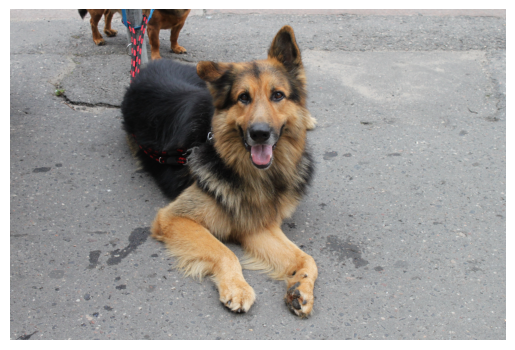

Image tensor on device:
---------------
cpu

Inputs information:
---------------
shape:torch.Size([1, 3, 224, 224])
class: <class 'torch.Tensor'>

Shape of outputs:
---------------
torch.Size([1, 1000])

Pred Index:
---------------
235

Pred Label:
---------------
German shepherd



In [6]:
with open("../data/labels.txt", 'r') as f:
    labels = [label.strip() for label in f.readlines()]

img = Image.open("../data/dog.jpg")

plt.imshow(img)
plt.axis('off')
plt.show()

img_tensor = preprocess(img).unsqueeze(0)
img_tensor = img_tensor.to(device)

with torch.no_grad():
    output = model(img_tensor)

y_original = output[0].argmax()

print(f"Image tensor on device:\n---------------\n{img_tensor.device}\n")
print(f"Inputs information:\n---------------\nshape:{img_tensor.shape}\nclass: {type(img_tensor)}\n")
print(f"Shape of outputs:\n---------------\n{output.shape}\n")
print(f"Pred Index:\n---------------\n{output[0].argmax()}\n")
print(f"Pred Label:\n---------------\n{labels[output[0].argmax().item()]}\n")

unnormed_img_tensor= unnormalize(img_tensor)


In [7]:
def adversarial_satisfactory(samples, target, clip_min, clip_max):
    samples = torch.clamp(samples, clip_min, clip_max)
    
    with torch.no_grad():
        preds = model(samples).argmax(dim=1)
    
    # any other class
    result = preds != target
    return result

In [8]:
# We're going to routinely clamp the images to this range to make sure that the algorithm doesn't "cheat" by giving us an image that could never be generated from a 24-bit image.
clip_min = -2
clip_max = +2

# randomly seed the generator
generator = torch.Generator().manual_seed(0)

In [9]:
# now generate a misclassified sample; we'll give ourselves 10 tries
for _ in range(10):
    random_img = torch.FloatTensor(img_tensor.shape).uniform_(clip_min,clip_max, generator=generator).to(device)
    random_class = model(random_img).argmax()

    if adversarial_satisfactory(random_img, y_original, clip_min, clip_max):
        initial_sample = (random_img, y_original)

        print(f"Found misclassified image: {random_class}")
        break

Found misclassified image: 92


In [10]:
threshold = 0.01 / torch.sqrt(torch.prod(torch.tensor(img_tensor.shape, dtype=torch.float).to(img_tensor.device)))
print(f"Threshold for ending the binary search is: {threshold:.10f}")

Threshold for ending the binary search is: 0.0000257746


In [11]:
upper_bound, lower_bound = 1,0 

while (upper_bound - lower_bound) > threshold:
    midpoint = (upper_bound + lower_bound) / 2.0
    
    interpolated_sample = (1 - midpoint) * img_tensor + midpoint * random_img
    
    if adversarial_satisfactory(interpolated_sample, y_original, clip_min, clip_max):
        # the decision boundary lies between midpoint and lower
        upper_bound, lower_bound = midpoint, lower_bound
    else:
        # it's the other way
        upper_bound, lower_bound = upper_bound, midpoint
    print("upper:", upper_bound, "lower:", lower_bound)
    
boundary_adversarial_example = (1-upper_bound)*img_tensor + upper_bound*random_img

upper: 0.5 lower: 0
upper: 0.25 lower: 0
upper: 0.25 lower: 0.125
upper: 0.25 lower: 0.1875
upper: 0.25 lower: 0.21875
upper: 0.25 lower: 0.234375
upper: 0.25 lower: 0.2421875
upper: 0.24609375 lower: 0.2421875
upper: 0.244140625 lower: 0.2421875
upper: 0.2431640625 lower: 0.2421875
upper: 0.24267578125 lower: 0.2421875
upper: 0.242431640625 lower: 0.2421875
upper: 0.242431640625 lower: 0.2423095703125
upper: 0.24237060546875 lower: 0.2423095703125
upper: 0.242340087890625 lower: 0.2423095703125
upper: 0.2423248291015625 lower: 0.2423095703125


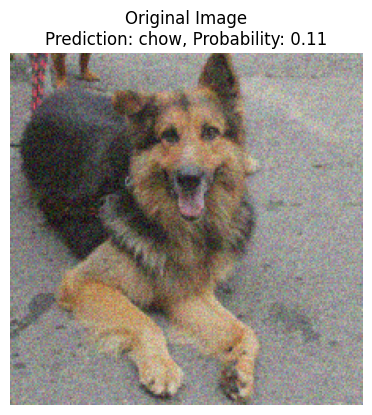

In [12]:
with torch.no_grad():
    output = model(boundary_adversarial_example)
    probs = torch.softmax(output, dim=1)[0][output[0].argmax()].item()
    prediction = labels[output[0].argmax()]
    
    unnormed_img_tensor= unnormalize(boundary_adversarial_example)
    img_pil = transforms.functional.to_pil_image(unnormed_img_tensor[0])

    
plt.figure(figsize=(10, 5))  # Adjust the figsize as needed
plt.subplot(1, 2, 1)
plt.imshow(img_pil)
plt.title(f"Original Image\nPrediction: {prediction}, Probability: {probs:.2f}")
plt.axis('off')
plt.show()

In [13]:
gradient_samples = 500
perturbation_scale = 0.1 * (clip_max - clip_min)  # This is going to be different on subsequent steps -- see page 6 of the paper

# Now we sample
perturbation_shape = [gradient_samples] + list(img_tensor.squeeze(0).shape)

# create our new rando tensors
perturbations = torch.randn(*perturbation_shape).to(device)

# to avoid clipping, we're going to take this noise and renormalize it elementwise
perturbations = perturbations / torch.sqrt(torch.sum(
    perturbations**2,                                     # Mean squared error
    axis = tuple(range(len(perturbation_shape)))[1:],     # We want to normalize each sample individually
    keepdims=True,                                        # but don't change the shape of the result
))

# now make the samples we'll be computing the gradients from
eval_samples = torch.clamp(boundary_adversarial_example + perturbation_scale*perturbations, clip_min, clip_max)

# and label them as being satisfactory or not
eval_labels = adversarial_satisfactory(eval_samples, y_original, clip_min, clip_max)

# and convert to +/-1 to mark which side of the decision bounadary they're on
signs = torch.where(eval_labels, 1., -1.)

# and expand to a 4-d tensor bc math
signs = signs.reshape([gradient_samples, 1, 1, 1])

# deal with the edge cases of all samples being of only one class, iykyk
if signs.min()==1.0:  # no -1 means no 'false' satisfactions
    unnormalized_gradient = torch.mean(perturbations, axis = 0)
elif signs.max()==-1.0:
    unnormalized_gradient = -torch.mean(perturbations, axis = 0)
else: #we've got some of each
    mean_signs = torch.mean(signs)
    unnormalized_gradient = torch.mean((signs - mean_signs) * perturbations, axis = 0)

normalized_gradient = unnormalized_gradient / torch.norm(unnormalized_gradient)

: 

In [ ]:
# This is a rough ballpark: just "jump _this_ far to the other side of the boundary"
step_size = torch.norm(boundary_adversarial_example - img_tensor)
print(f"Step size: {step_size}")

Step size: 155.6714324951172


In [ ]:
done=False
while not done:
    new_anchor = boundary_adversarial_example + step_size * normalized_gradient
    if adversarial_satisfactory(new_anchor, y_original, clip_min, clip_max):
        done=True
    step_size/=2.0 # reduce the step size until we succeed in misclassifying

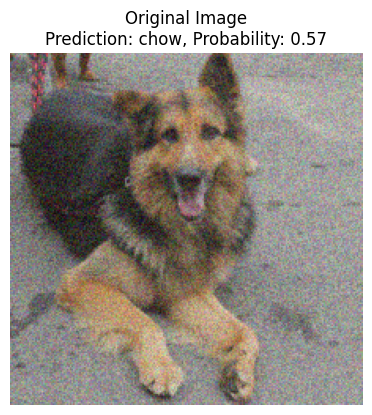

In [ ]:
with torch.no_grad():
    output = model(new_anchor)
    probs = torch.softmax(output, dim=1)[0][output[0].argmax()].item()
    prediction = labels[output[0].argmax()]
    
    unnormed_adv_tensor= unnormalize(new_anchor)
    img_pil = transforms.functional.to_pil_image(unnormed_img_tensor[0], 'RGB')

    
plt.figure(figsize=(10, 5))  # Adjust the figsize as needed
plt.subplot(1, 2, 1)
plt.imshow(img_pil)
plt.title(f"Original Image\nPrediction: {prediction}, Probability: {probs:.2f}")
plt.axis('off')
plt.show()

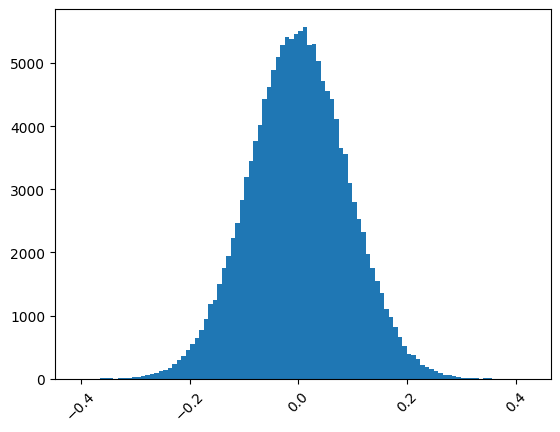

Minimum and maximum difference between the images: -0.406480073928833 0.42340540885925293


In [ ]:
difference = unnormed_adv_tensor - unnormed_img_tensor
difference_list = difference.view(-1).tolist()

# Plot the histogram
plt.hist(difference_list, bins=100)
plt.xticks(rotation=45)
plt.show()

print("Minimum and maximum difference between the images:", difference.min().item(), difference.max().item())